In [6]:
import datetime
import logging

import netCDF4
import xarray as xr
import matplotlib as mpl
import cdsapi
import numpy as np
import warnings
import regionmask
import matplotlib.pyplot as plt
import pandas as pd
warnings.filterwarnings('ignore')
plt.style.use('default')
import cftime
import os
import seaborn as sns
import cartopy
import cartopy.feature as cpf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box, mapping
import geopandas as gpd
import rioxarray
from matplotlib import cm
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import texttable
from tqdm.notebook import trange, tqdm
from xclim import ensembles
import global_land_mask
import iris

import sys
sys.path.append("../Farallon/QIN/CMIP6-downscale/")
sys.path.append("../Farallon/QIN/CMIP6-downscale/isimip3basd/")
from CMIP6_ridgeplot import CMIP6_ridgeplot
import CMIP6_downscale_iris
from CMIP6_model import CMIP6_MODEL
from CMIP6_plot import CMIP6_GLORYS12_plot
from cartopy.util import add_cyclic_point

In [7]:
def convert_to_180(ds):
 #   ds=ds.assign_coords(lat=ds.y)
    return (ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))).sortby('lon')

def convert_time(ds):
    if not ds.indexes["time"].dtype in ["datetime64[ns]"]:

        time_objects = ds.indexes['time'].to_datetimeindex() 
        ds=ds.assign_coords({"time": time_objects})                   
        ds = xr.decode_cf(ds)
        
    return ds

def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (time,lat,lon)
    """

    # Use add_cyclic_point to interpolate input data
    print(da.dims)
    lon_idx = 2 #da.dims.index('lon')

    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data,
                           coords = {'time': da.time, 'lat': da.lat, 'lon': wrap_lon},
                           dims=da.dims,
                           attrs=da.attrs)

    return outp_da

def create_land_ocean_mask(cmip6_grid: xr.Dataset) -> xr.DataArray:
    print("[create_land_ocean_mask] Running create_land_ocean_mask")
    lon = cmip6_grid.lon.values
    lat = cmip6_grid.lat.values
    lon_180 = xr.where(lon > 180, lon - 360, lon)

    lon_grid, lat_grid = np.meshgrid(lon_180, lat)

    mask_data = global_land_mask.globe.is_ocean(lat_grid, lon_grid).astype(int)
    #  mask_data[np.isnan(mask_data)] = np.nan

    return xr.DataArray(mask_data, coords={'lat': lat, 'lon': lon},
                        dims=['lat', 'lon'])

def calculate_areacello(ds, model_obj, var_name, project_name):

        # Calculate the area based on the longitude - latitude
        if ds.lon.ndim == 2:
            lon = ds.lon.values[0, :]
            lat = ds.lat.values[:, 0]
        else:
            lon = ds.lon.values
            lat = ds.lat.values

        ds_singletime = ds.isel(time=0)

        # Convert the dataset to a cube as this adds correct units required by iris
        sdiris = CMIP6_downscale_iris.CMIP6_downscale_iris()
        cube = sdiris.ds_to_iris(ds_singletime,
                                 var_name,
                                 model_obj,
                                 project_name, prefix="cube")

        # Calculate the areacello for the grid and convert the result to km2
        # Uses iris area_weights function.
        # https://scitools.org.uk/iris/docs/v2.4.0/iris/iris/analysis/cartography.html#iris.analysis.cartography.area_weights
        m2_to_km2 = 1.0e-6
        area_ends = (iris.analysis.cartography.area_weights(cube, normalize=False)) * m2_to_km2

        # Now convert the numpy array of areas to a dataset with the same dimension as the siconc
        area_ds = xr.DataArray(name="areacello",
                               data=area_ends,
                               coords={"lat": lat,
                                       "lon": lon},
                               dims=["lat", "lon"]).to_dataset()

        # Convert the resulting dataset to an iris cube
        area_cube = sdiris.ds_to_iris(area_ds,
                                      "areacello",
                                      model_obj,
                                      project_name,
                                      prefix="areacello_")

        # Fix the coordinates so that we add geographic information to the cube,
        # before saving the cube to the siconc dataset
        area_cube = sdiris.fix_coordinates_cube(area_cube)

        return xr.DataArray.from_iris(area_cube)


def get_area_averaged_ds(fname, model, scenario, ensemble_id, var_name, LME, create_maps, frequency, models_dict):
    
    if os.path.exists(fname):
        with xr.open_dataset(fname) as ds:
            ds = convert_to_180(ds)
            ds = ds.sel(time=slice(start_time,end_time))

            ds = convert_time(ds)
            ds_lme = get_data_within_LME(ds, var_name, LME, False)
            ds_lme = xr_add_cyclic_point(ds_lme[var_name])
            ds_lme = ds_lme.to_dataset(name=var_name)

            # Add land mask
            ds_lme["mask"] = create_land_ocean_mask(ds_lme)
            ds_lme = ds_lme.where(ds_lme.mask == 1)
            model_obj = CMIP6_MODEL(model)

            ds_lme["areacello"] = calculate_areacello(ds_lme, model_obj, var_name, project_name="light")
            # Clip the area to the polygon - this also clips to the time varying var_name# which results in
            # time varying areacello variable that we can use to sum up the size of open water by
            # looking at the annual mean.
            # First we set all areas outside of the polygon to nan - which also now includes
            # areacello which as part of teh calculations actually covered the whole region (and
            # not just the polygon).
            ds_lme = xr.where(np.isnan(ds_lme[var_name]), np.nan, ds_lme)

            # Then we remove the areas where par or uv is less than a minimum value to remove zeroes etc.
            if var_name in ["par"]:
                ds_lme = xr.where(ds_lme[var_name]<1, np.nan, ds_lme)

            elif var_name in ["uvb"]:
                ds_lme = xr.where(ds_lme[var_name]<0.001, np.nan, ds_lme)
            total_area_lme = np.nansum(ds_lme["areacello"].mean(dim="time").values)
            print("[calculate_areacello] Average total area {:,.2f} km2".format(total_area_lme))


            if LME in ["Barents Sea","Arctic Ocean"]:
                projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
                extent = [-10, 80, 67, 85]
            else:
                projection=ccrs.PlateCarree(central_longitude=-180)
                extent = [-184, -155, 60, 80]
                extent = [-200, -145, 50, 85]

            if create_maps:
                fig = plt.figure(figsize=(13, 8))
                ax1 = fig.add_subplot(111, projection=projection)
                create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),
                                  True,extent,ds_lme["areacello"].isel(time=-1))
                plt.show()
            # Average data within the LME as a function of time
            ds = ds_lme.mean({"lat","lon"})

            # To get the average sum of the open water areas we sum prio to creating the
            # dataframe. Then when running rolling mean we just get the summed value back smoothed.
            ds = ds.assign(areacello = ds_lme["areacello"].sum({"lat","lon"}))

            df = ds.to_dataframe().dropna()
            df = df.reset_index()

        roll_years=5
        df=df.resample(frequency, on="time").mean()

        df["model_name"]=model
        df["roll_mean"]=df[var_name].rolling(roll_years).mean()
        df["roll_mean_area"]=df["areacello"].rolling(roll_years).mean()
        df["roll_median"]=df[var_name].rolling(roll_years).median()
        df["roll_max"]=df[var_name].rolling(roll_years).max()
        df["roll_min"]=df[var_name].rolling(roll_years).min()

        df["model_ensemble_id"]=ensemble_id
        df["model_scenario"]=scenario
        df["model_name_scenario"]=model+"_"+scenario
        unique="{}_{}_{}".format(model, scenario, ensemble_id)
        df["unique"]=unique

        model_info={}
        model_info["model_name"]=model
        model_info["model_scenario"]=scenario
        model_info["model_ensemble_id"]=ensemble_id
        model_info["model_var"]=var_name
        key="{}_{}_{}_{}".format(model,ensemble_id,scenario,var_name)
        formatter="{:.2f}"
        model_info["model_min"]=formatter.format(np.nanmin(df[var_name]))
        model_info["model_max"]=formatter.format(np.nanmax(df[var_name]))

        models_dict[key]=model_info
        return df, models_dict, ds_lme, total_area_lme, extent, projection
    else:
        return None, models_dict, None, None, None, None

In [8]:
def get_LME_records():
    lme_file='../oceanography/Shapefiles/LME66/LMEs66.shp'
    return gpd.read_file(lme_file)

def get_LME_records_plot():
    lme_file='../oceanography/Shapefiles/LME66_180/LME66_180.shp'
    return gpd.read_file(lme_file)

def create_colors(N):
    color=iter(cm.tab20b(np.linspace(0,1,N)))
    return [next(color) for c in range(N)]


def create_LME_figure(ax, LMES, projection, show, extent,data_to_contour=None):

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    
    ax.set_extent(extent)

    # Get the -180-180 projected shapefile containing LMEs to make it
    # easy to plot across the Pacific Ocean
    shdf = get_LME_records_plot()
    colors_rgb=create_colors(len(LMES))
    counter=0
    for LME_NAME,LME_NUMBER in zip(shdf['LME_NAME'],shdf['LME_NUMBER']):

        shdf_sel = shdf[ shdf['LME_NAME']==LME_NAME ]

        if (LME_NAME in LMES):
           # print("Adding geometry for LME {}".format(LME_NAME))
            # Add the geometry and fill it with color
            if len(LMES)==1:
                color="red"
            else:
                color=colors_rgb[counter]
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor=color,
                              edgecolor='k',
                              zorder=8)
            if data_to_contour is not None:

                ax.contourf(data_to_contour.lon,
                            data_to_contour.lat,
                            data_to_contour,
                            zorder=10,
                   cmap=sns.color_palette("Spectral_r", as_cmap=True),
                   transform=ccrs.PlateCarree())

            # Add the label LME_NUMBER of the selected LME at the center of the LME
          #  ax.annotate(s=LME_NUMBER,
          #              xy=(shdf_sel.centroid.x,shdf_sel.centroid.y),
          #              color="white",
          #              fontsize=13)
            counter+=1
        else:
            ax.add_geometries(shdf_sel['geometry'],
                              projection,
                              facecolor='LightGray',
                              edgecolor='k')

    if show:
        plotfile="Figures/CMIP6_lightpaper_map_{}.png".format(LMES[0])
        print("Created figure {}".format(plotfile))
        plt.savefig(plotfile, dpi=200,
                        bbox_inches = 'tight')
        plt.show()

def get_data_within_LME(ds,var_name,LME,create_maps):

    print("Working on LME: {}".format(LME))
    
    # Extract the polygon defining the boundaries of the LME
    shdf = get_LME_records()
   # for name in shdf['LME_NAME']:
   #     print(name)
    shdf_sel = shdf[ shdf['LME_NAME']==LME ]

    # Create the map of the LME boundaries and color it.
    # The active LME has color while the others are grey.
    if create_maps:
        # Setup the figure panels
        fig = plt.figure(figsize=(13, 8))
        if LME in ["Barents Sea","Arctic Ocean"]:
            projection=ccrs.NorthPolarStereo() #ccrs.PlateCarree(central_longitude=0)
            extent = [-8, 80, 67, 90]
        else:
            projection=ccrs.PlateCarree(central_longitude=-180)
            extent = [-252, -100, 10, 65]
            extent = [-220, -135, 30, 85]
        ax1 = fig.add_subplot(111, projection=projection)
    
        create_LME_figure(ax1, [LME], ccrs.PlateCarree(central_longitude=-180),True,extent)

    # Rioxarray requires x and y dimensions - we convert these back to lon and lat later.
    # We also add the projection (lat-lon) so that rioxarray can do the clipping of the data according to the
    # shapefile.

    tos=ds.rename({'lon': 'x','lat': 'y'})
    tos=tos.rio.write_crs(4326)

    # Clip the data within the LME. We have to convert the polygon geometry to a geodataframe using
    # `shapely.geometry`. The clipping of data within the polygon is done using rioxarray.clip function

    clipped = tos.rio.clip(geometries=shdf_sel.geometry.apply(mapping), crs=tos.rio.crs)
    clipped=clipped.rename({'x': 'lon','y': 'lat'}) #.to_dataset()

    p1="2000-01-01 to 2020-01-01"
    p2="2080-01-01 to 2020-01-01"

    create_maps=False
    if create_maps:
        clipped_p1=clipped.sel(time=slice("2000-01-01","2020-01-01")).mean({"time"})
       # clipped_p2=clipped.sel(time=slice("2080-01-01","2099-12-16")).mean({"time"})

        create_map(clipped_p1, "{} 2000-01-01 to 2020-01-01".format(var_name), var_name, period=p1, anomalies=False, details=False)
        #create_map(clipped_p2, "{} 2080-01-01 to 2020-01-01".format(var_name), var_name, period=p2, anomalies=False, details=False)

        plt.show()
    return clipped

In [9]:
def create_summary_table(dict_of_models, LME):
    table = texttable.Texttable()
    table.set_cols_align(["c","c", "c","c","c","c","c"])
    table.set_cols_valign(["t","t", "m","m","m","m", "b"])

    table.header(["LME","Model", "Scenario", "ID", "Var", "CMIP6 min", "CMIP6 max"])
    for key in dict_of_models.keys():
        model=dict_of_models[key]

        table.add_row([LME,
                       model["model_name"],
                       model["model_scenario"],
                       model["model_ensemble_id"],
                       str(model["model_var"]),
                       str(model["model_min"]),
                       str(model["model_max"])])

    table.set_cols_width([30,30,20,20,10,10,10])
    print(table.draw() + "\n")

Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created figure Figures/CMIP6_lightpaper_map_East Bering Sea.png


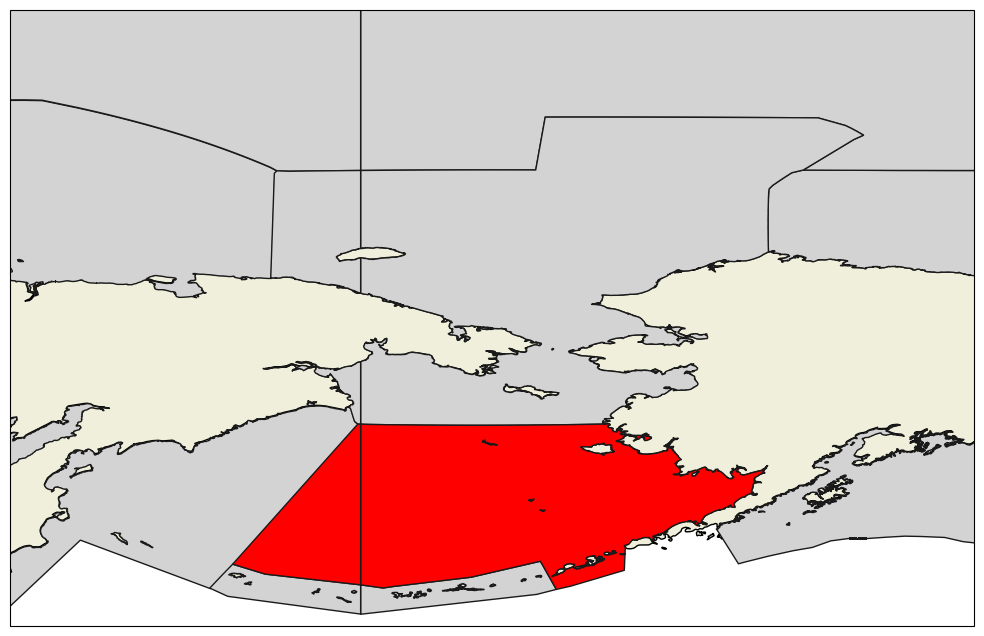

Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


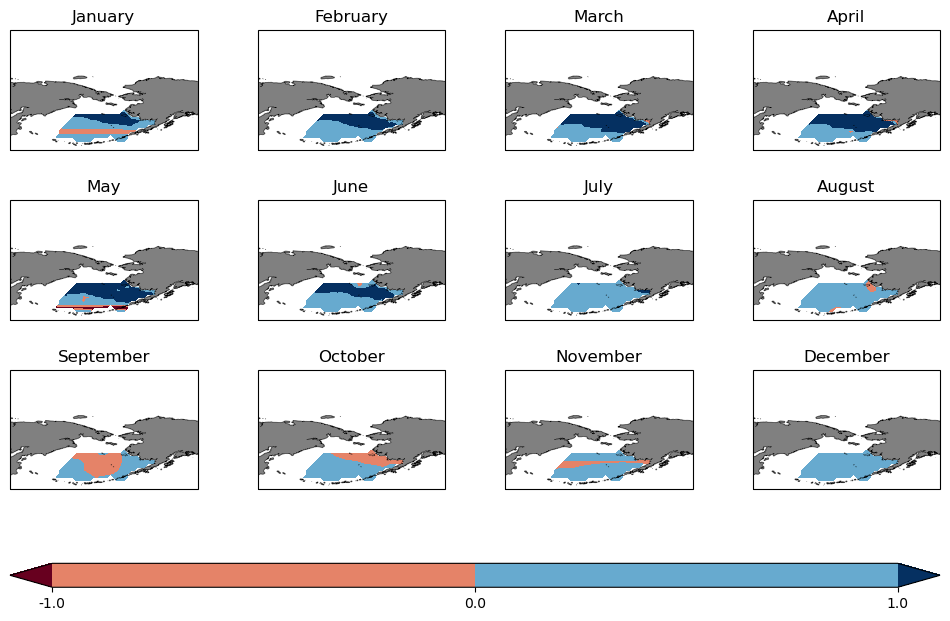

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


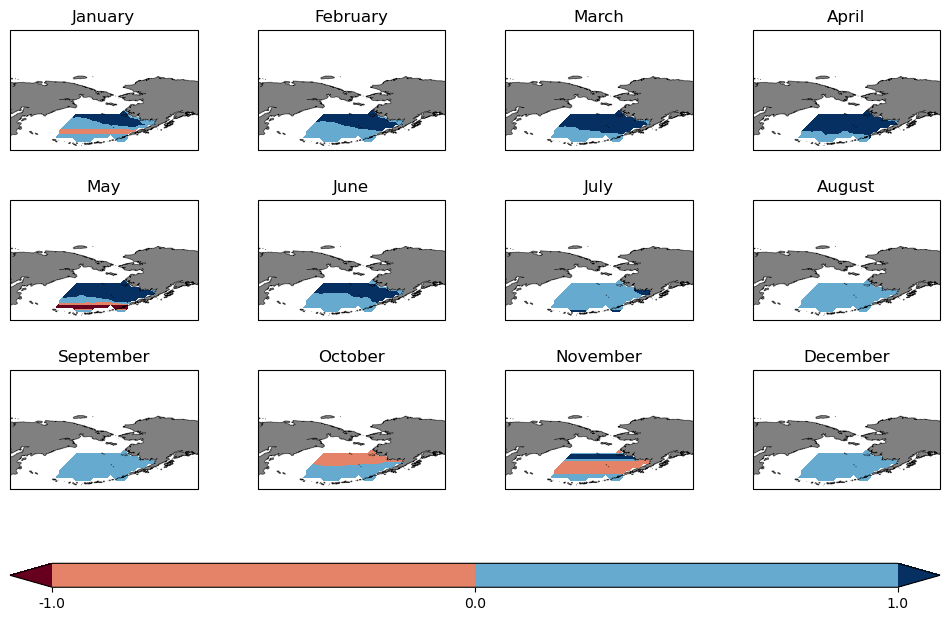

Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: East Bering Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp585.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


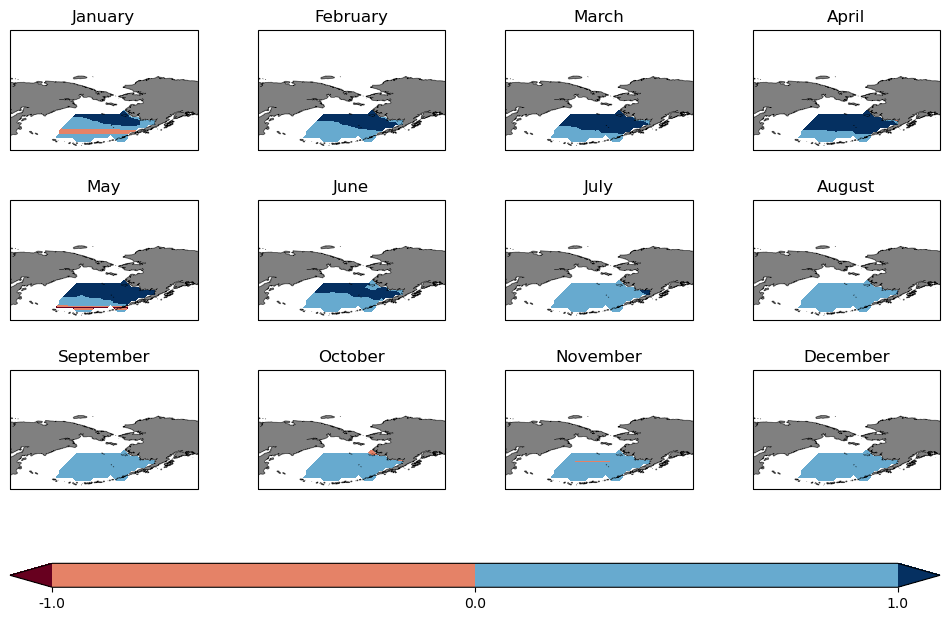

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


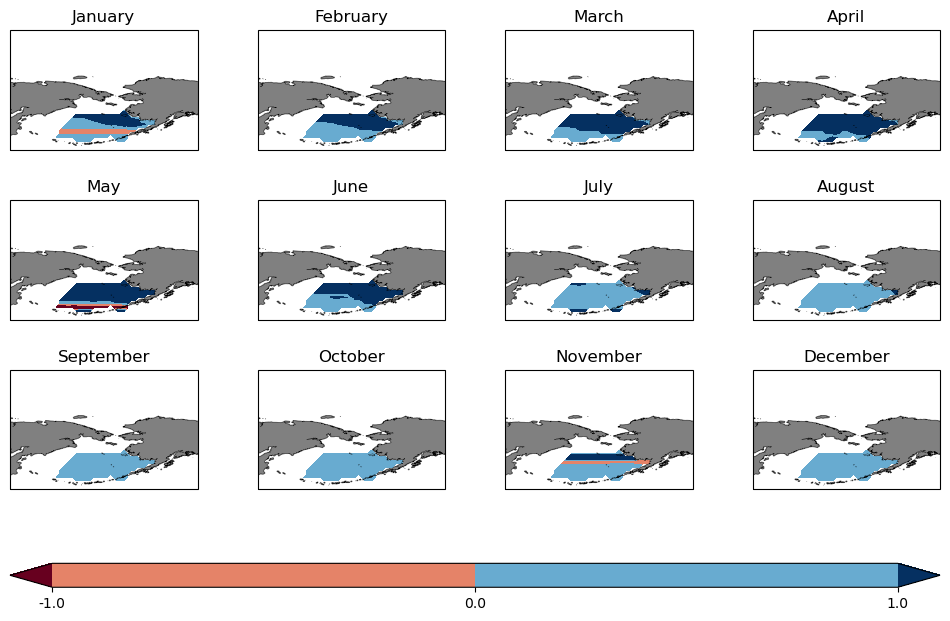

+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
|              LME               |             Model              |       Scenario       |          ID          |    Var     | CMIP6 min  | CMIP6 max  |
+================================+================================+======================+======================+============+============+============+
|        East Bering Sea         |         ACCESS-ESM1-5          |        ssp245        |       r1i1p1f1       |     uv     |   13.340   |   17.880   |
+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
|        East Bering Sea         |         MPI-ESM1-2-LR          |        ssp245        |       r2i1p1f1       |     uv     |   12.440   |   17.930   |
+--------------------------------+--------------------------------+---------------

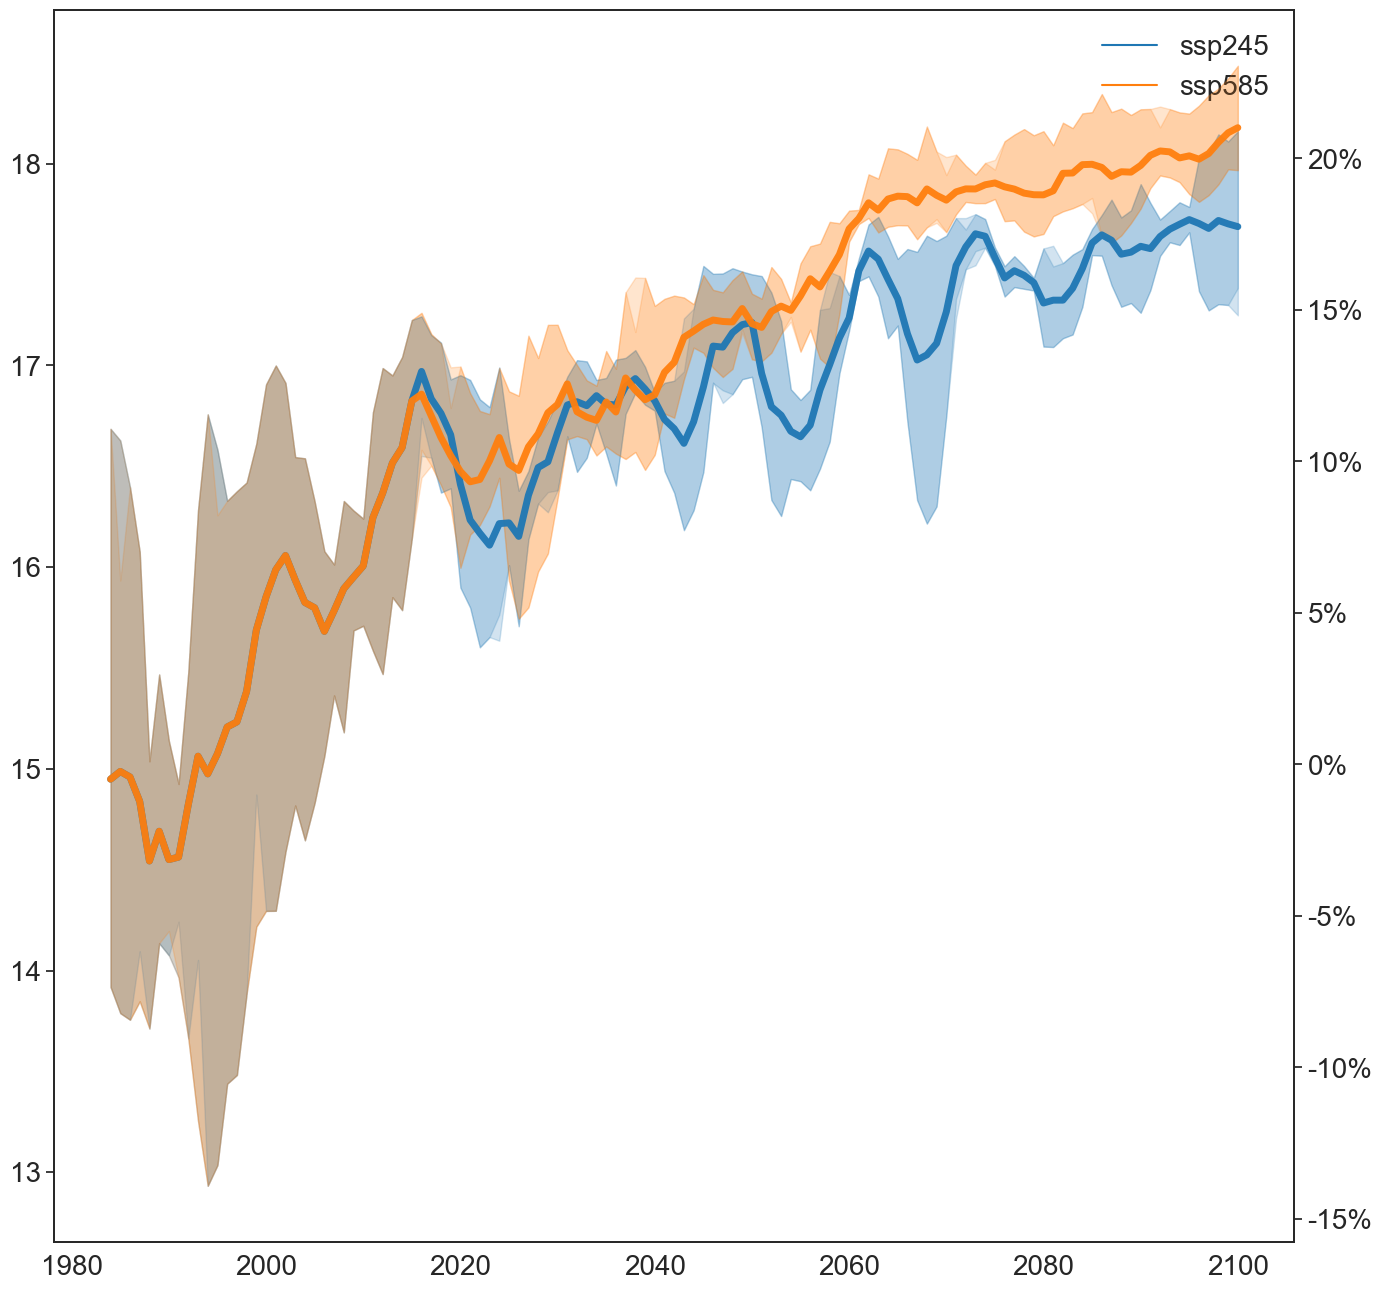

Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 2,014,185.04 km2
Created figure Figures/CMIP6_lightpaper_map_Barents Sea.png


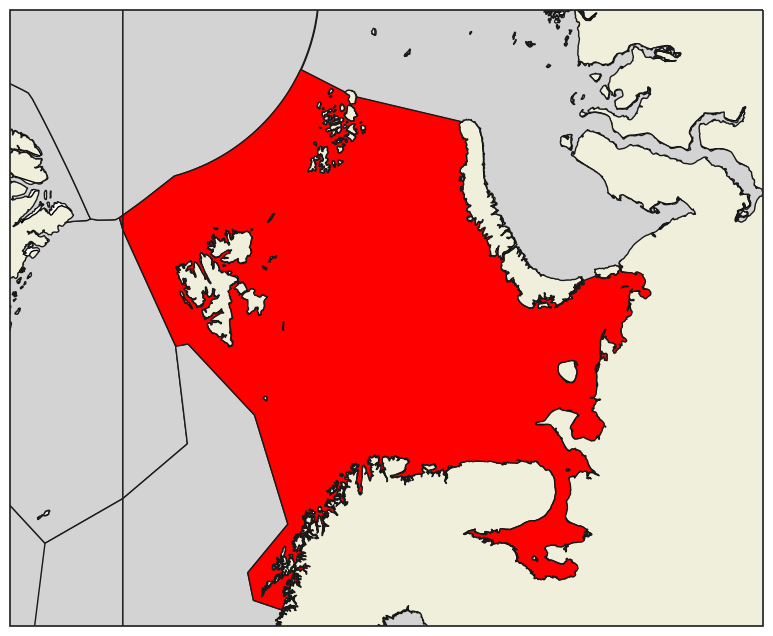

Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 2,014,185.04 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 2,014,185.04 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


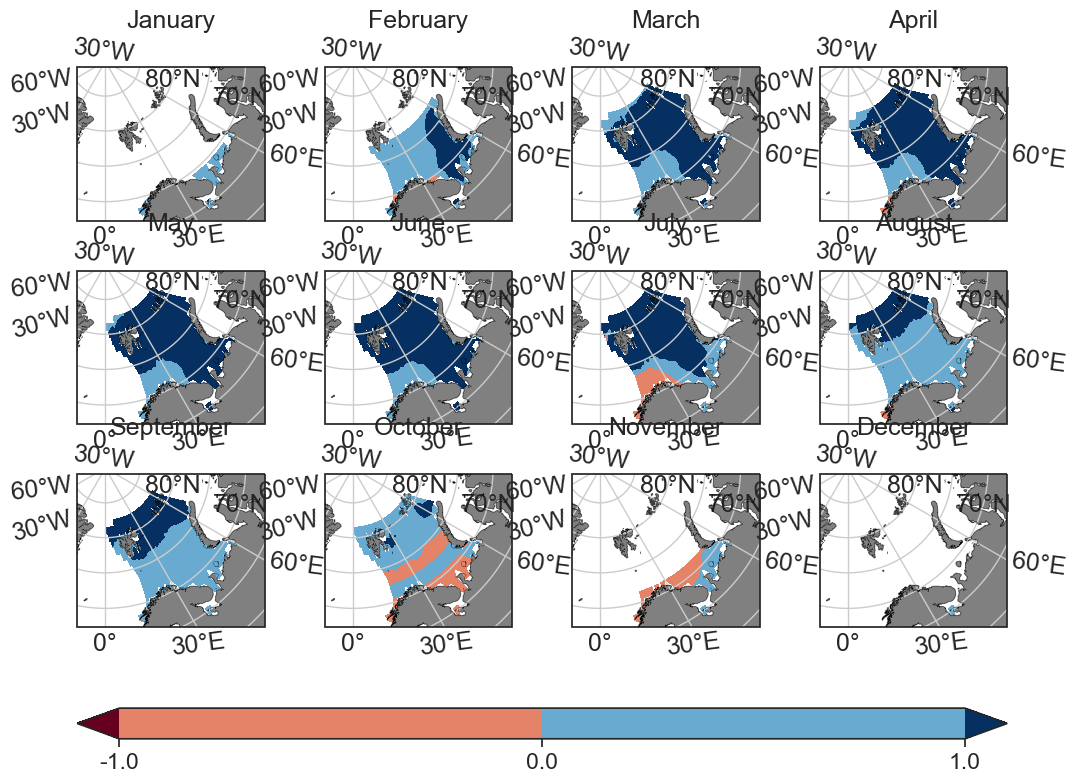

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


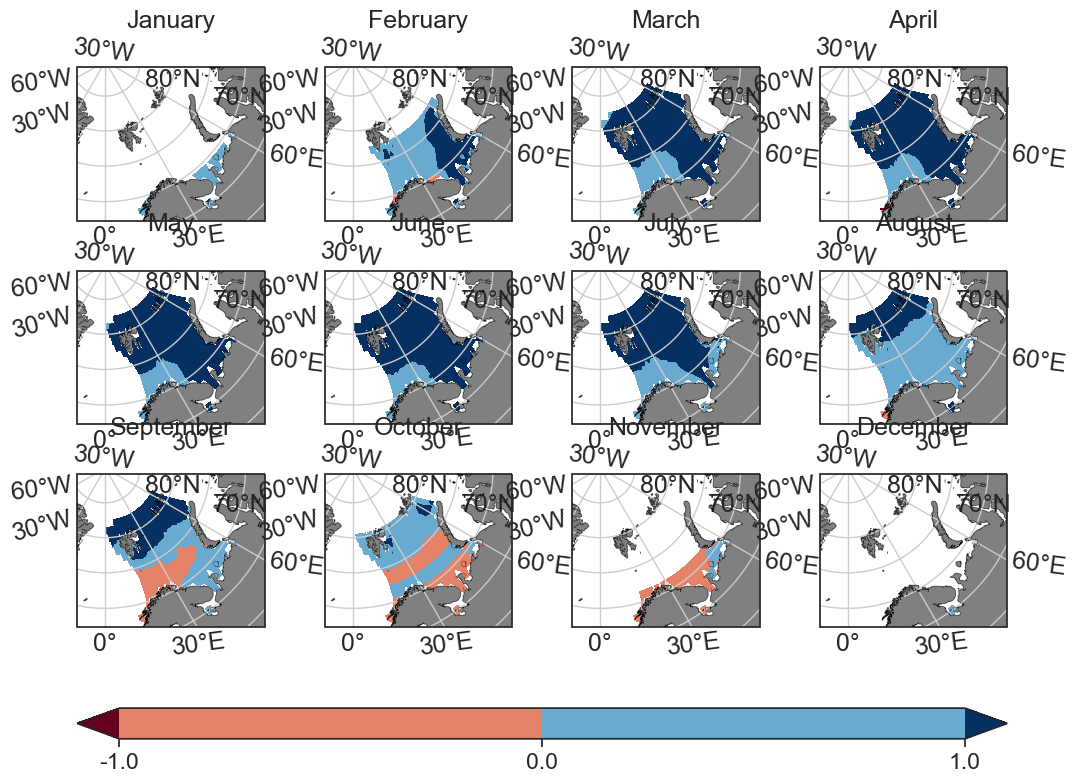

Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 2,014,185.04 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 2,014,185.04 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: Barents Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask
[calculate_areacello] Average total area 2,014,185.04 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp585.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


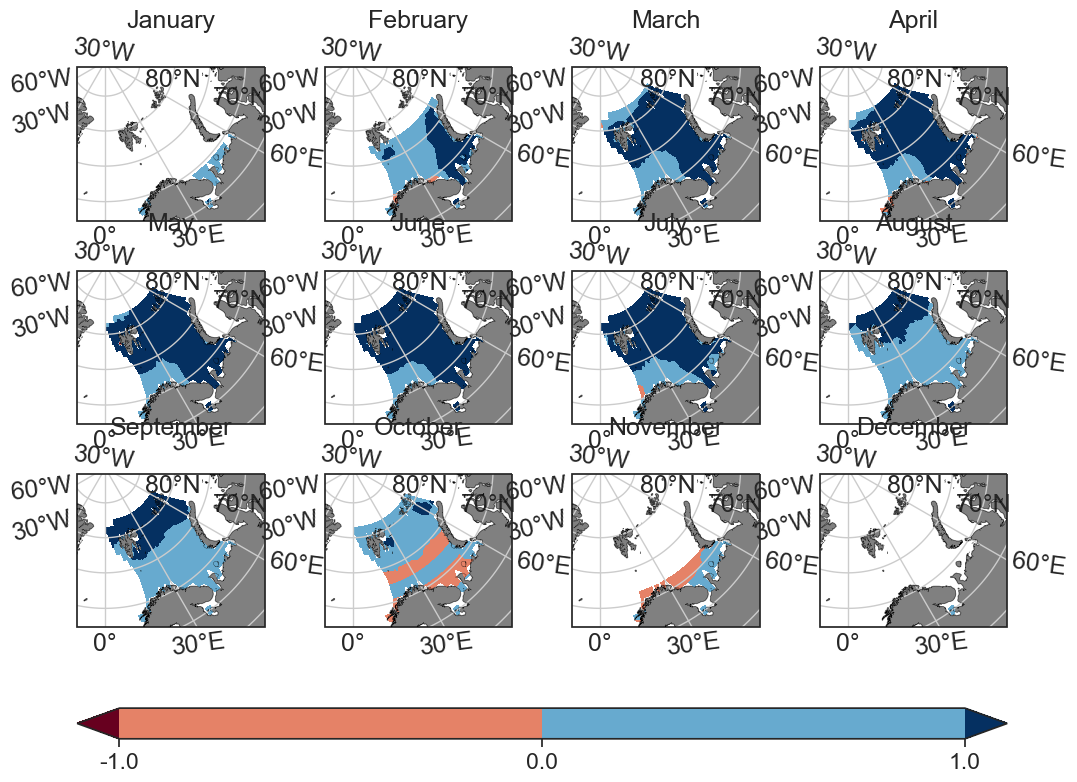

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


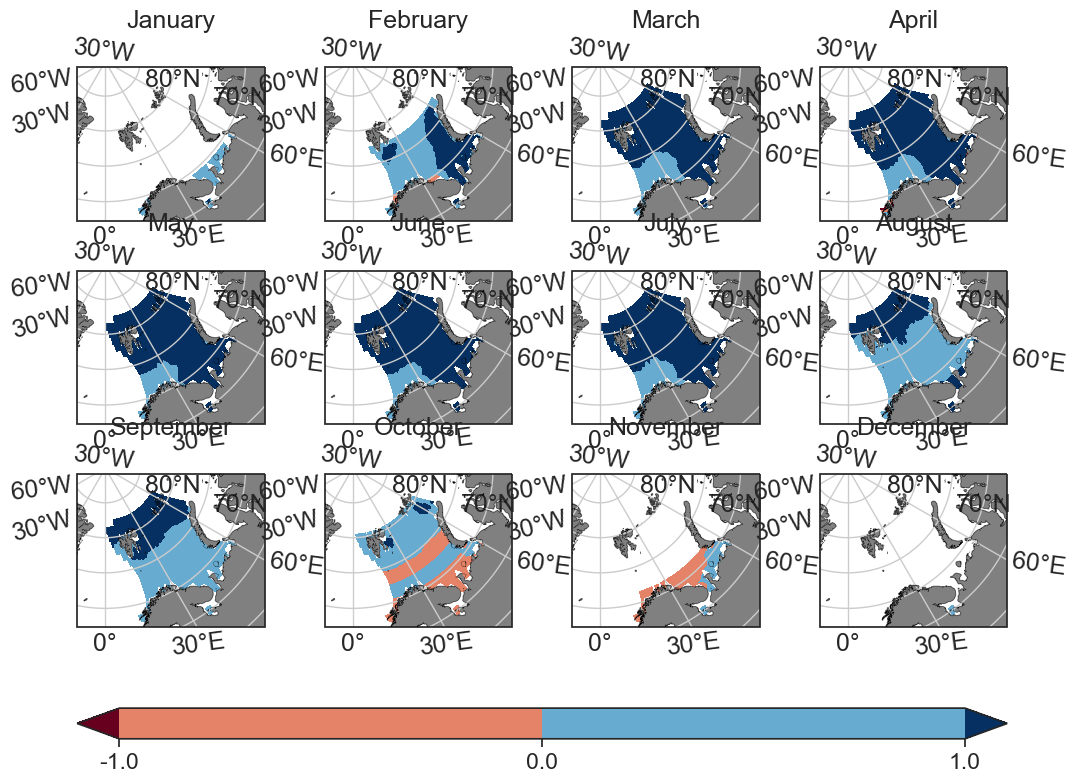

+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
|              LME               |             Model              |       Scenario       |          ID          |    Var     | CMIP6 min  | CMIP6 max  |
+================================+================================+======================+======================+============+============+============+
|          Barents Sea           |         ACCESS-ESM1-5          |        ssp245        |       r1i1p1f1       |     uv     |   5.290    |   11.380   |
+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
|          Barents Sea           |         MPI-ESM1-2-LR          |        ssp245        |       r2i1p1f1       |     uv     |   6.110    |   11.270   |
+--------------------------------+--------------------------------+---------------

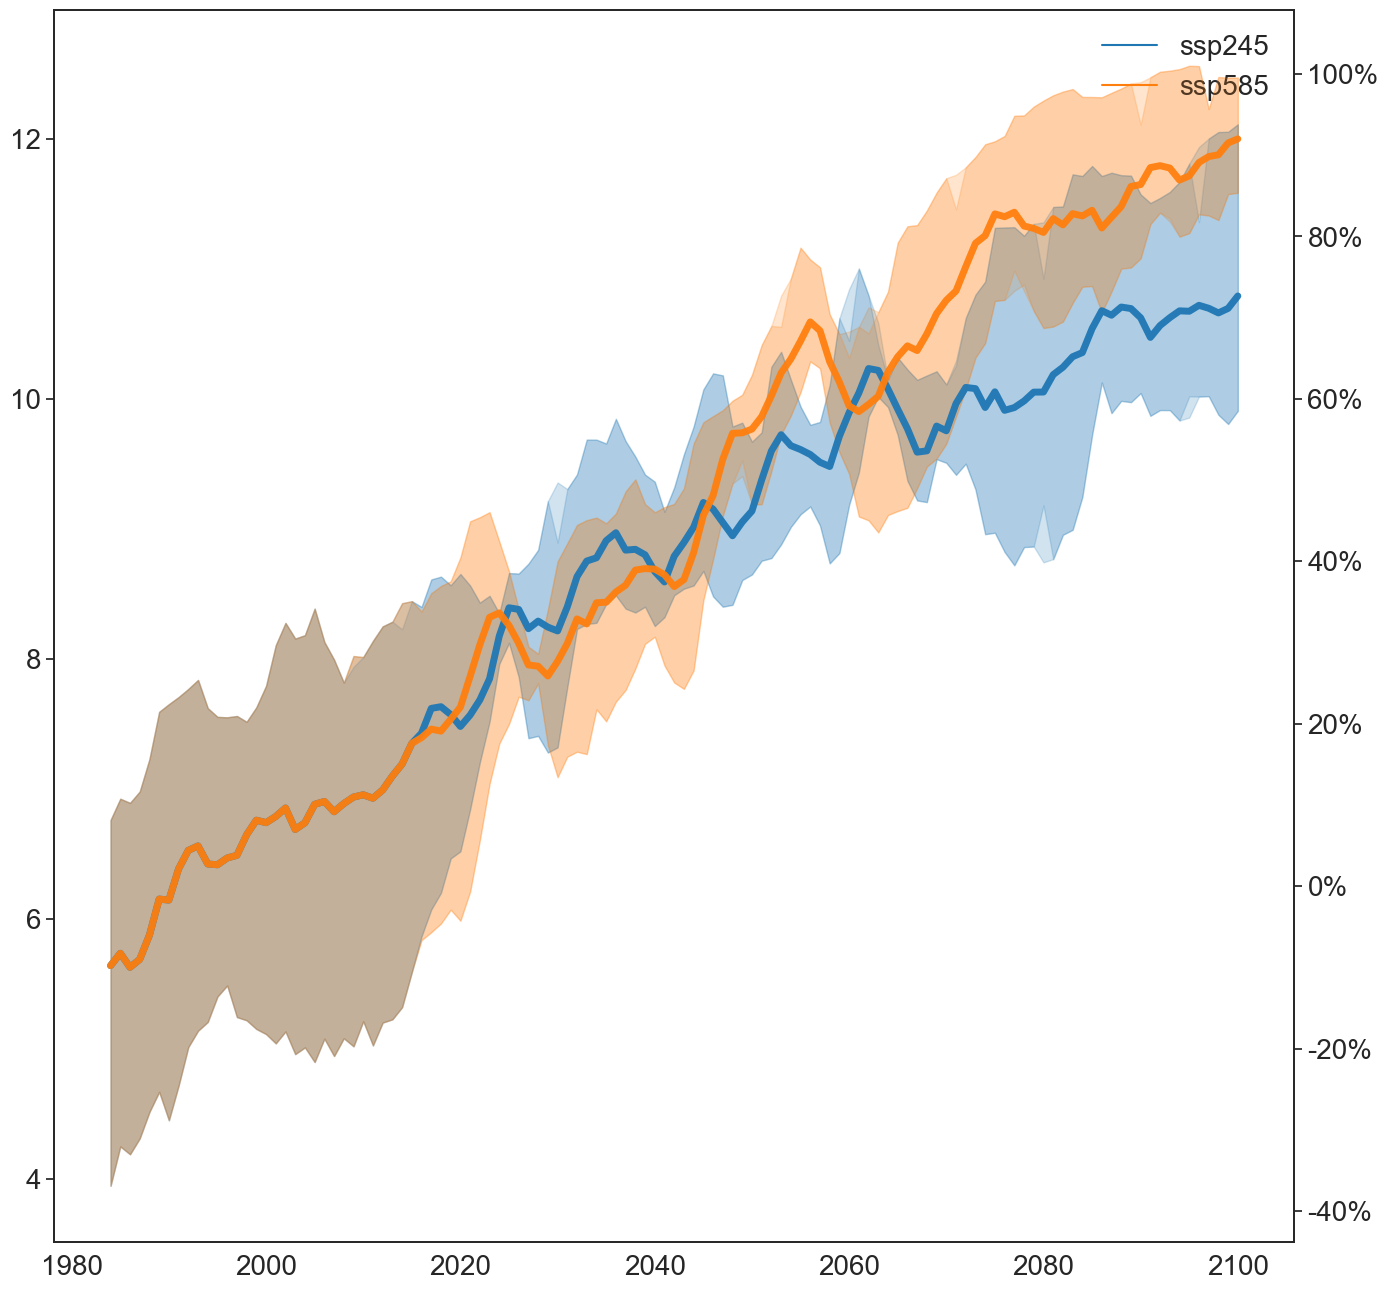

Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created figure Figures/CMIP6_lightpaper_map_Northern Bering - Chukchi Seas.png


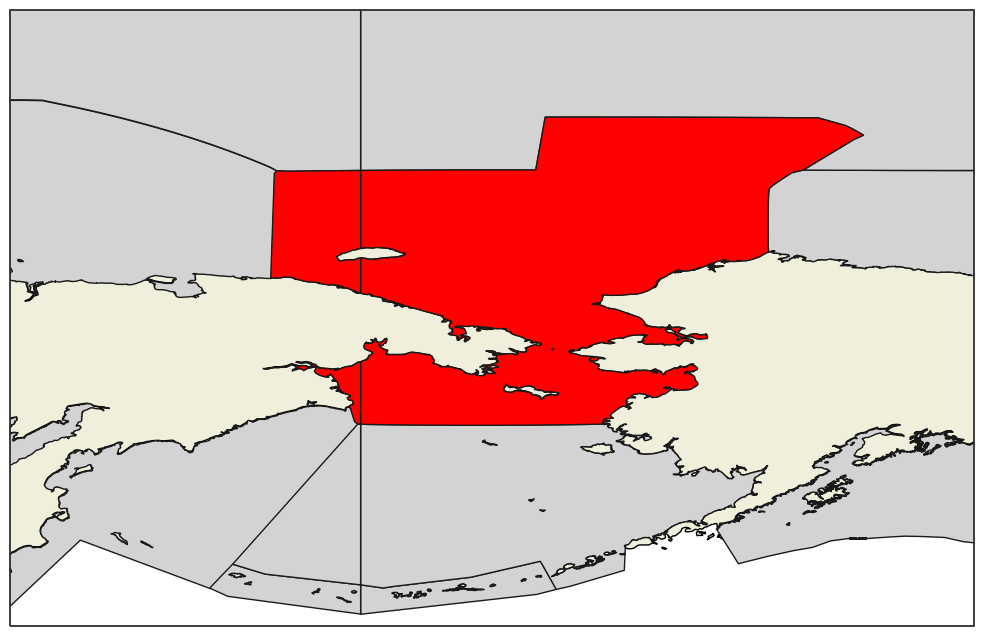

Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


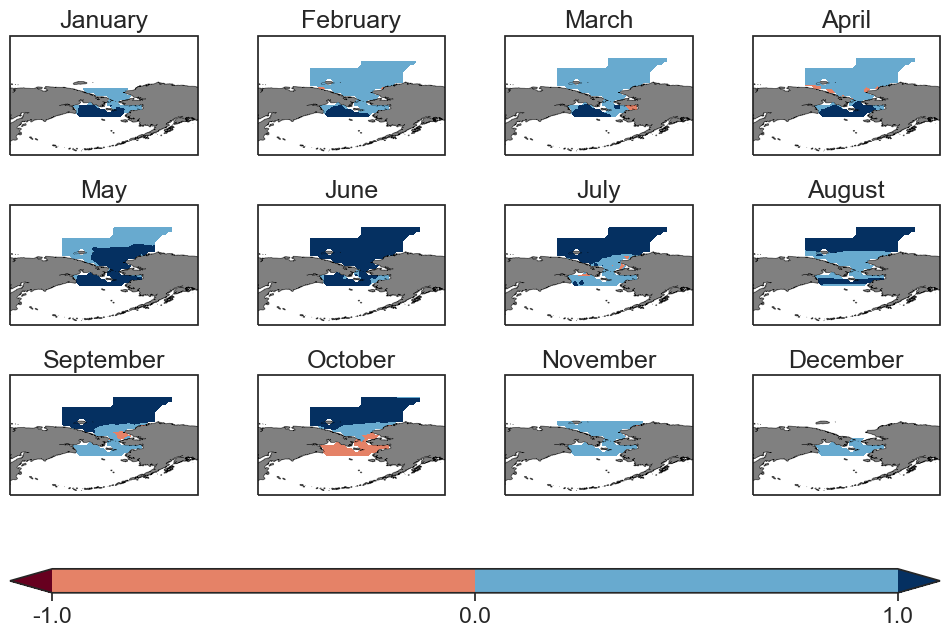

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


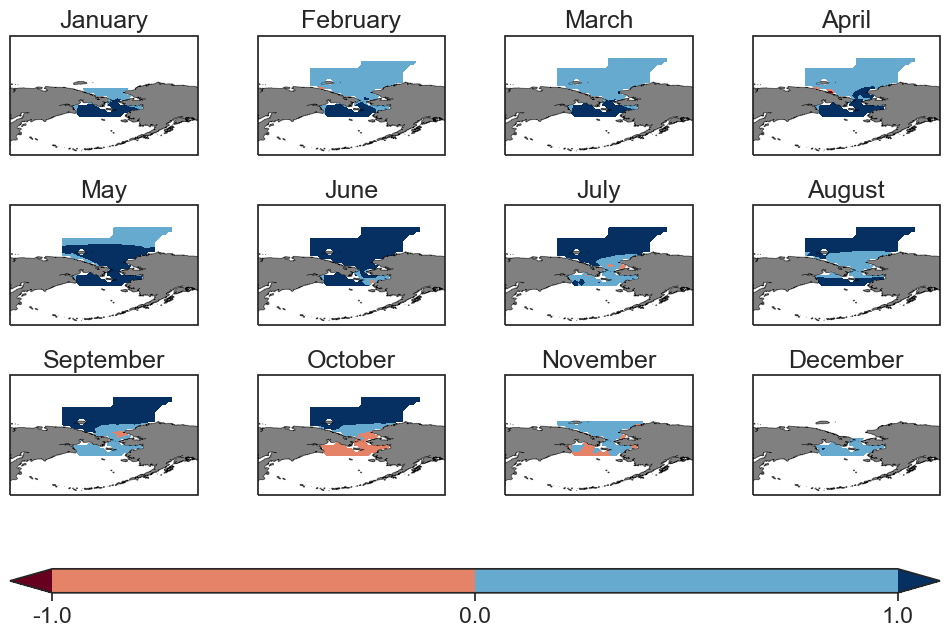

Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp585.nc
Working on LME: Northern Bering - Chukchi Seas
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,409,037.30 km2
Created dataframe of file: ../oceanography/light/ncfiles/uv_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp585.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


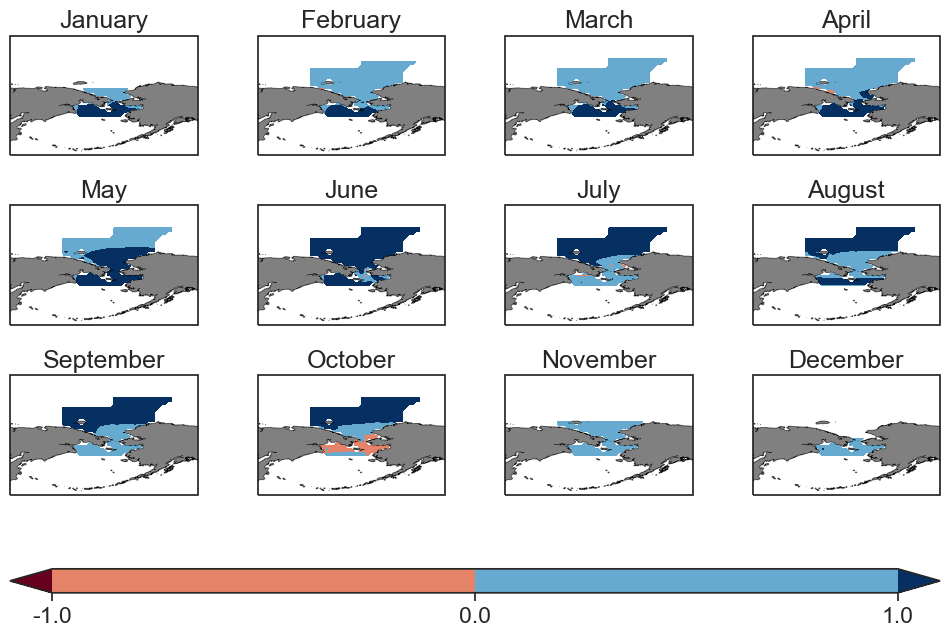

[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


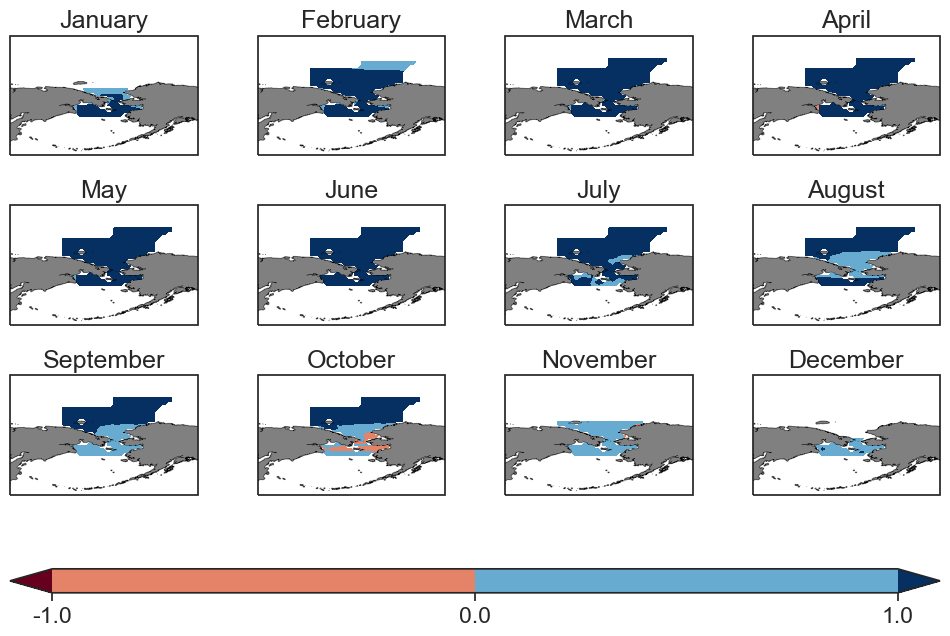

+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
|              LME               |             Model              |       Scenario       |          ID          |    Var     | CMIP6 min  | CMIP6 max  |
+================================+================================+======================+======================+============+============+============+
| Northern Bering - Chukchi Seas |         ACCESS-ESM1-5          |        ssp245        |       r1i1p1f1       |     uv     |   3.930    |   9.470    |
+--------------------------------+--------------------------------+----------------------+----------------------+------------+------------+------------+
| Northern Bering - Chukchi Seas |         MPI-ESM1-2-LR          |        ssp245        |       r2i1p1f1       |     uv     |   5.890    |   10.150   |
+--------------------------------+--------------------------------+---------------

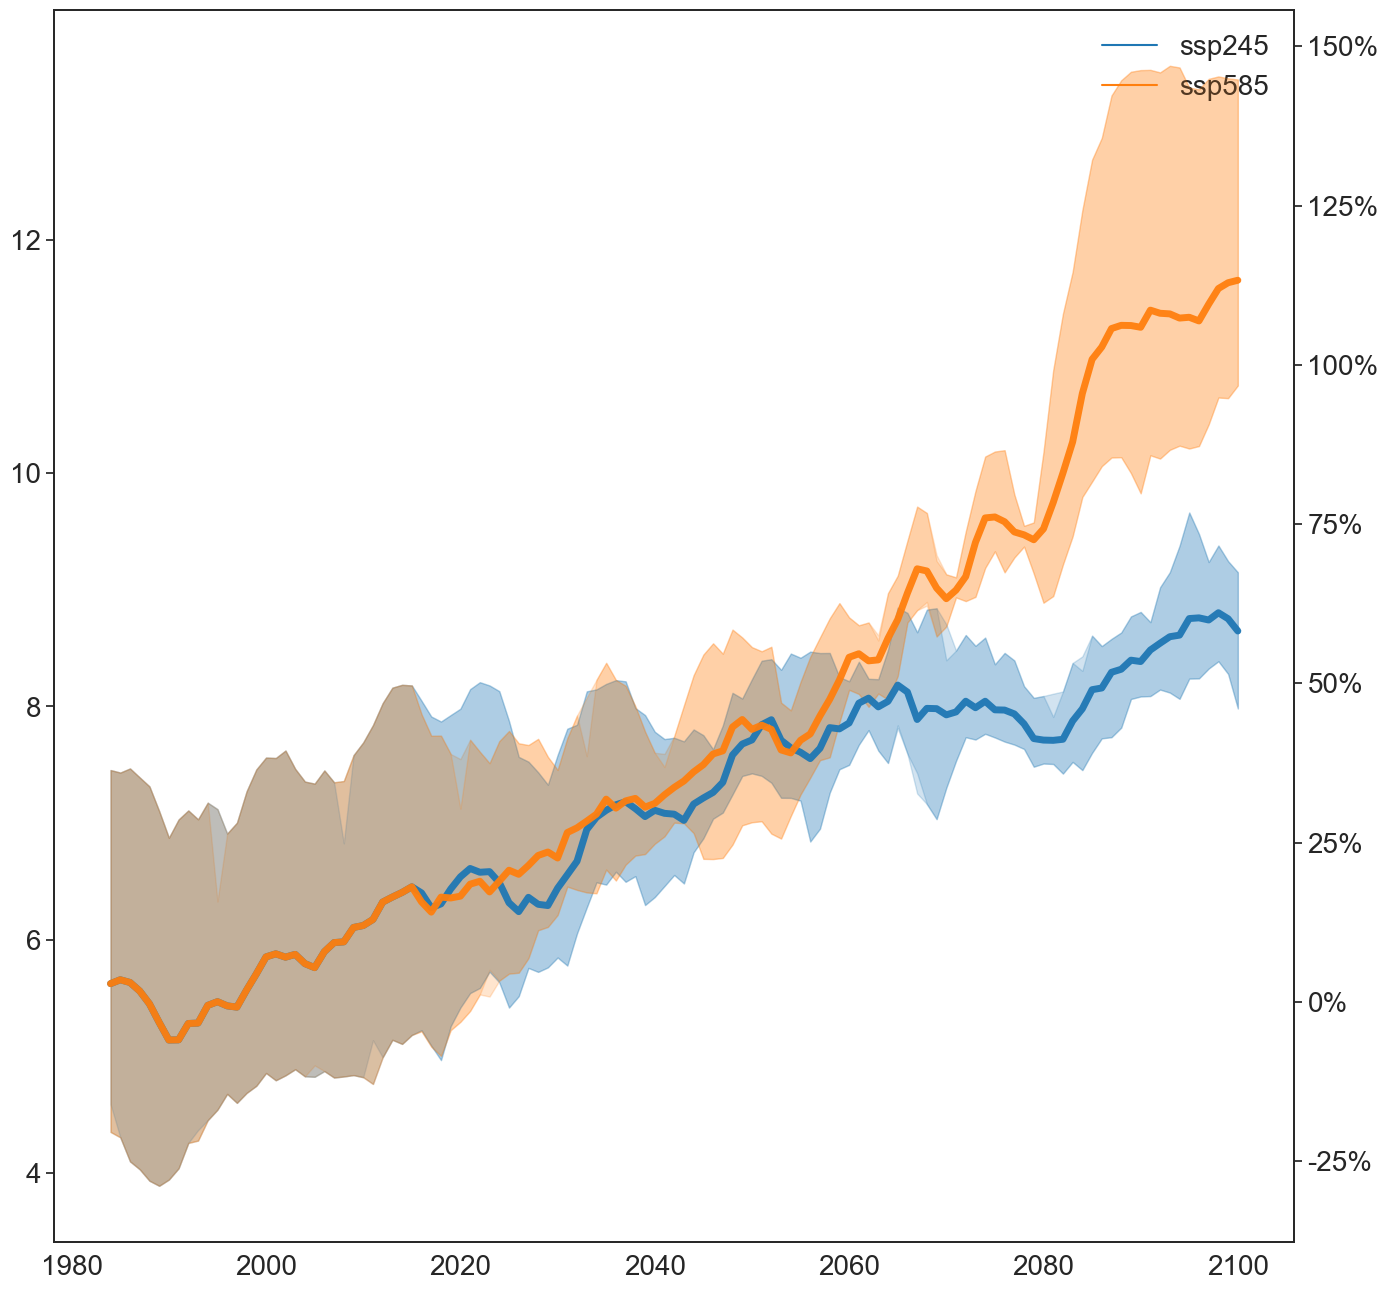

Working on LME: East Bering Sea
('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created figure Figures/CMIP6_lightpaper_map_East Bering Sea.png


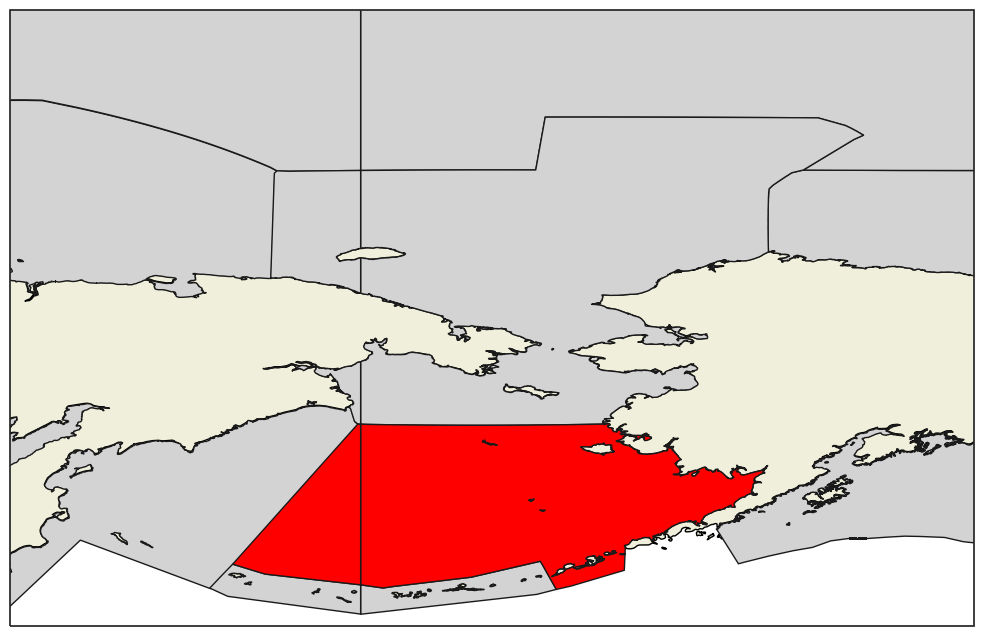

Created dataframe of file: ../oceanography/light/ncfiles/uvb_ACCESS-ESM1-5_r1i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: East Bering Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uvb_MPI-ESM1-2-LR_r2i1p1f1_1979-01-01-2099-12-16_scenario_osa_ssp245.nc
Working on LME: East Bering Sea


('time', 'lat', 'lon')
[create_land_ocean_mask] Running create_land_ocean_mask


[calculate_areacello] Average total area 1,333,145.97 km2
Created dataframe of file: ../oceanography/light/ncfiles/uvb_UKESM1-0-LL_r1i1p1f2_1979-01-01-2099-12-16_scenario_osa_ssp245.nc


[CMIP6_plot] Creating climatology plot for 1979-01-01 to 2099-12-16


IndexError: index 0 is out of bounds for axis 0 with size 0

In [10]:
scenarios = ["ssp245", "ssp585"]
member_range = 12
frequency = "A"
ensemble_ids = ["r{}i{}p{}f{}".format(str(i + 1), str(ii + 1), str(iii + 1), str(iv + 1)) for i in
                range(member_range)
                for ii in range(member_range) for iii in range(member_range) for iv in range(member_range)]
period = "1979-01-01-2099-12-16"
start_time = "1979-01-01"
end_time = "2099-12-16"

models = ["ACCESS-ESM1-5", "MPI-ESM1-2-LR", "CMCC-ESM2", "UKESM1-0-LL"]
# "CanESM5-CanOE","UKESM1-0-LL","MPI-ESM1-2-HR"]

#models=["CMCC-ESM2"]

ds_var_names = ["par", "uvb", "uv"]
ds_var_names = ["uv","uvb"]  #,"uv"]
write_stats_to_file = False

LMES = ['California Current', 'East Bering Sea', 'Gulf of Alaska',
        'Northern Bering - Chukchi Seas', 'West Bering Sea', 'Sea of Japan',
        'Oyashio Current', 'Kuroshio Current', 'East China Sea',
        'South China Sea', 'Sea of Okhotsk', 'Yellow Sea',
        'Aleutian Islands']

LMES = ['Barents Sea', 'Northern Bering - Chukchi Seas', 'Central Arctic']
LMES = ['East Bering Sea','Barents Sea', 'Northern Bering - Chukchi Seas'] #, 'Central Arctic', 'East Bering Sea']

for var_name in ds_var_names:
    for LME in LMES:
        df_list = []
        models_dict = {}
        simulation = "osa"
        create_maps = True
        saved_total_area_lme = None
        saved_extent = None
        saved_projection = None
        # We loop over all of the scenarios, ensemble_ids, and models to create a
        # list of dataframes that we eventually concatenate together and plot
        for scenario in scenarios:
            ds_list = []

            for model in models:
                for ensemble_id in ensemble_ids:

                    fname = "../oceanography/light/ncfiles/{}_{}_{}_{}_scenario_{}_{}.nc".format(var_name,
                                                                                                 model,
                                                                                                 ensemble_id,
                                                                                                 period,
                                                                                                 simulation,
                                                                                                 scenario)

                    df, models_dict, ds_lme, total_area_lme, extent, projection = get_area_averaged_ds(fname, model,
                                                                                                       scenario,
                                                                                                       ensemble_id,
                                                                                                       var_name, LME,
                                                                                                       create_maps,
                                                                                                       frequency,
                                                                                                       models_dict)

                    if ds_lme is not None:
                        saved_extent = extent
                        saved_projection = projection
                        saved_total_area_lme = total_area_lme
                        ds_lme = xr.where(((ds_lme < 1.e-20) | (ds_lme > 1e20)), np.nan, ds_lme)
                        ds_list.append(ds_lme)
                    create_maps = False
                    if df is not None:
                        df_list.append(df)
                        print("Created dataframe of file: {}".format(fname))

            if len(ds_list) > 0:
                ens = ensembles.create_ensemble(ds_list).load()
                ens.close()
                ens_stats = ensembles.ensemble_mean_std_max_min(ens)

                outfile = "Figures/{}_ensemble_{}_{}.png".format(var_name.capitalize(), scenario, LME)

                plot_clim=True
                if plot_clim:
                    for clim_start_time, clim_end_time in zip(["2050-01-01", "2080-01-01"],
                                                              ["2060-01-01", "2090-01-01"]):
                        print("[CMIP6_plot] Creating climatology plot for {} to {}".format(start_time, end_time))

                        cmip6 = CMIP6_GLORYS12_plot()
                       # ens_stats = xr.where(ens_stats==0, 0, 1)

                        cmip6.plot_monthly_climatology("{}_mean".format(var_name),
                                                       "surface", "20",
                                                       ens_stats,
                                                       "Figures/",
                                                       prefix="light",
                                                       start_time=clim_start_time,
                                                       end_time=clim_end_time,
                                                       delta=True,
                                                       extent=saved_extent,
                                                       projection=saved_projection)

                #    CMIP6_ridgeplot.ridgeplot("{}_mean".format(var_name),
                #                              None, outfile,
                #                                      glorys=False, depth_threshold=None,
                #                                      ds=ens_stats)

        if len(df_list) > 0:
            df = pd.concat(df_list)

            create_summary_table(models_dict, LME)
            df['time'] = pd.to_datetime(df.index, errors='coerce', format='%Y-%m-%d')

            clim = df["roll_mean"].loc['1980-01-01':'2000-01-01'].mean()

            df["rel_change"] = ((df["roll_mean"] - float(clim)) / float(clim)) * 100.


            sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)
            f = plt.figure(figsize=(16, 16))
            gs = f.add_gridspec(1, 1)
            ax = f.add_subplot(gs[0, 0])

            sns.set_palette("tab10")

            b = sns.lineplot(ax=ax, data=df, x=df.index, y=df["roll_mean"],
                             hue=df["model_scenario"],
                             alpha=.0, ci=95, linewidth=0)

            b.tick_params(labelsize=20)
            b.set_xlabel("", fontsize=14)
            b.set_ylabel("", fontsize=14)

            plt.legend(loc="upper right", frameon=False, fontsize=20)

            ax2 = ax.twinx()
            b2 = sns.lineplot(ax=ax2, data=df, x=df.index, y=df["rel_change"],
                              hue=df["model_scenario"],
                              alpha=.95, ci=95, linewidth=5, label=None)

            b2.tick_params(labelsize=20)
            b2.set_xlabel("", fontsize=14)
            b2.set_ylabel("", fontsize=14)
            ylabels = ['{:,.0%}'.format(y) for y in b2.get_yticks() / 100.]
            b2.set_yticklabels(ylabels)

            b2.get_legend().remove()

            if not os.path.exists("Figures"):
                os.makedirs("Figures")
            plotfile = "Figures/CMIP6_light_{}_{}.png".format(var_name, LME)
            print("Created figure {}".format(plotfile))
            plt.savefig(plotfile, dpi=200,
                        bbox_inches='tight')

            plt.show()

            # Plot individual figure the open water area
            if var_name in ["par"]:
                f2 = plt.figure(figsize=(16, 16))
                gs2 = f2.add_gridspec(1, 1)
                ax2 = f2.add_subplot(gs2[0, 0])

                # Colors from deep default seaborn palette found here:
                # https://github.com/mwaskom/seaborn/blob/master/seaborn/palettes.py
                palette = sns.color_palette(["#8172B3", "#64B5CD"])
                sns.set_palette(palette)

                # Add extra variable - percentage change in size of open water area.
                df["change_open_water"] = (df["roll_mean_area"] / float(saved_total_area_lme)) * 100.

                # Plot the results
                # Note that we do not actually plot the roll_mean_area in axis ax2 only in ax3 below

                b11 = sns.lineplot(ax=ax2, data=df, x=df.index, y=df["roll_mean_area"],
                                 hue=df["model_scenario"],
                                 alpha=.0, ci=95, linewidth=0)
                ax2.legend(loc="upper left", frameon=False, fontsize=20)

                b11.tick_params(labelsize=20)
                b11.set_xlabel("", fontsize=14)
                b11.set_ylabel("", fontsize=14)

                # Format the yticks
                # https://mkaz.blog/code/python-string-format-cookbook/
                ylabels = ['{:,}'.format(y) for y in b11.get_yticks()]
                b11.set_yticklabels(ylabels)

                print("Open water calculations range from {} on {} to {} in {}".format(df["change_open_water"].iloc[0],
                                                                                       df["time"].iloc[0],
                                                                                       df["change_open_water"].iloc[-1],
                                                                                       df["time"].iloc[-1]))
                ax3 = ax2.twinx()
                b22 = sns.lineplot(ax=ax3, data=df, x=df.index, y=df["change_open_water"],
                                  hue=df["model_scenario"],
                                  alpha=.95, ci=95, linewidth=5, label=None)

                b22.tick_params(labelsize=20)
                b22.set_xlabel("", fontsize=14)
                b22.set_ylabel("", fontsize=14)
                ylabels = ['{:,.0%}'.format(y) for y in b22.get_yticks() / 100.]
                b22.set_yticklabels(ylabels)

                b22.get_legend().remove()

                plotfile = "Figures/CMIP6_light_{}_{}.png".format("area_open_water", LME)
                print("Created figure {}".format(plotfile))
                plt.savefig(plotfile, dpi=200,
                            bbox_inches='tight')

                plt.show()

        df = pd.DataFrame()
        ds_list = []